In [25]:
!pip install scikit-learn





In [26]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, mean_squared_error, log_loss, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [27]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/FinalYearProject"

In [30]:
def check_and_display_images(generator, class_labels, num_images=5):
    for label in class_labels:
        index = generator.class_indices[label]
        print(f"Class: {label}")

        batch = next(generator)

        # Filter images that belong to the current class
        class_images = batch[0][np.argmax(batch[1], axis=1) == index]

        valid_images = []
        for img in class_images:
            if np.mean(img) == 0 or np.var(img) == 0:
                print("Skipped a blank or invalid image.")
            else:
                valid_images.append(img)
            if len(valid_images) >= num_images:
                break

        if valid_images:
            num_valid_images = len(valid_images)
            fig, axes = plt.subplots(1, num_valid_images, figsize=(15, 15))

            if num_valid_images == 1:
                axes = [axes]
            for img, ax in zip(valid_images, axes):
                ax.imshow(img.astype('uint8'))
                ax.axis('off')
            plt.show()
        else:
            print(f"No valid images to display for class {label}")


In [32]:
initial_datagen = ImageDataGenerator(validation_split=0.2)

# Load the images
initial_generator = initial_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/Colab Notebooks/FinalYearProject'

In [ ]:
class_labels = list(initial_generator.class_indices.keys())


Class: 1. Eczema 1677


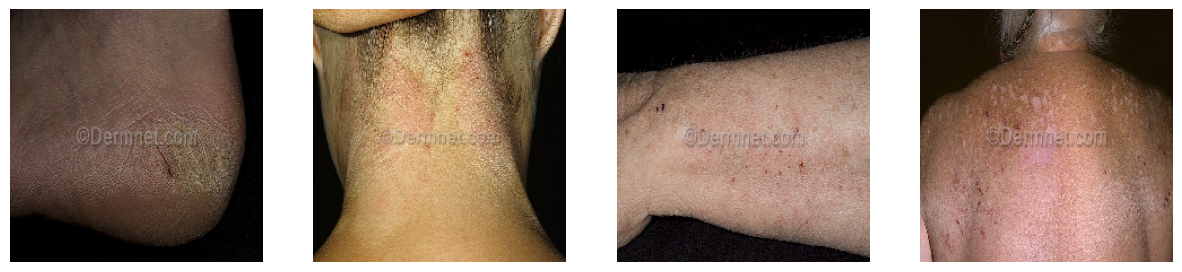

Class: 2. Melanoma 15.75k


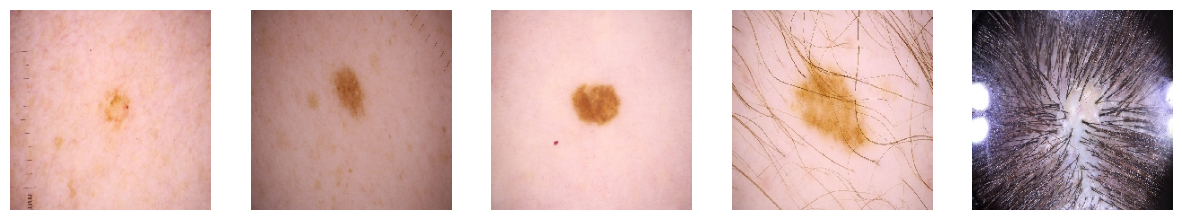

Class: 3. Atopic Dermatitis - 1.25k


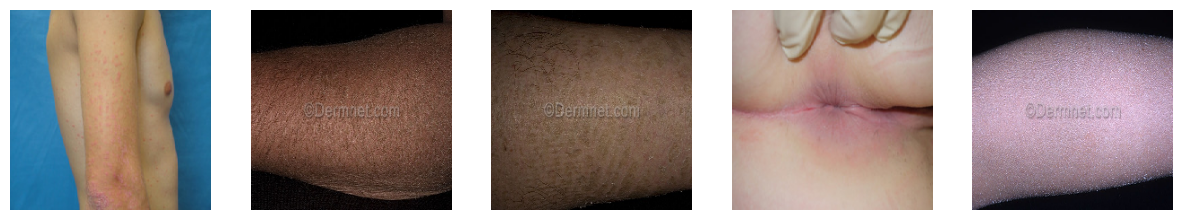

Class: 4. Basal Cell Carcinoma (BCC) 3323


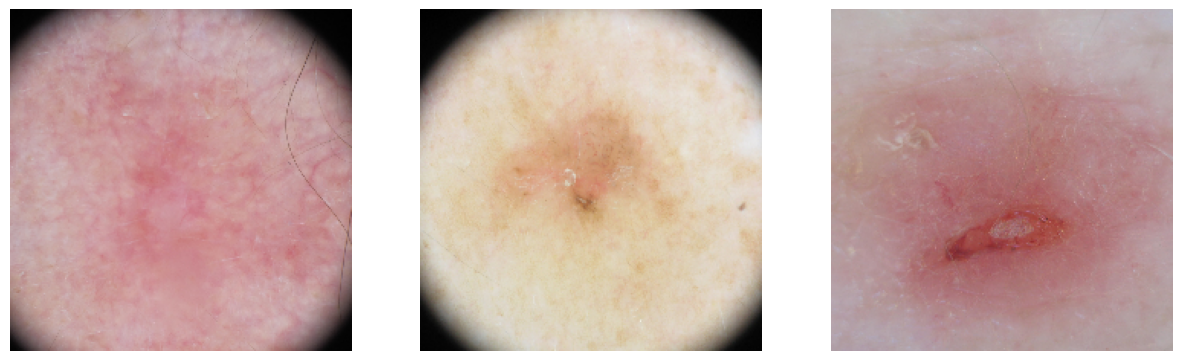

In [ ]:
check_and_display_images(initial_generator, class_labels)


In [ ]:
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 6083 images belonging to 4 classes.
Found 1519 images belonging to 4 classes.


In [ ]:
def build_model(optimizer):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(len(class_labels), activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
optimizers = {
    "Adam": Adam(learning_rate=0.001),
    "SGD": SGD(learning_rate=0.01, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=0.001)
}

In [ ]:
results = {}

for opt_name, opt in optimizers.items():
    print(f"\nTraining the model with {opt_name} optimizer...")

    model = build_model(opt)
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=5
    )

    print(f"\nEvaluating the model with {opt_name} optimizer...")
    val_loss, val_acc = model.evaluate(validation_generator)
    results[opt_name] = {
        "val_loss": val_loss,
        "val_acc": val_acc
    }

    # Predict on validation data
    print(f"\nGenerating predictions with {opt_name} optimizer...")
    y_true = validation_generator.classes
    y_pred = model.predict(validation_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Metrics Calculation
    accuracy = accuracy_score(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    mse = mean_squared_error(y_true, y_pred_classes)
    log_loss_value = log_loss(y_true, y_pred)

    results[opt_name].update({
        "accuracy": accuracy,
        "recall": recall,
        "f1_score": f1,
        "mse": mse,
        "log_loss": log_loss_value
    })

    print(f"\n{opt_name} Optimizer Results:")
    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_acc}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Recall Score: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Mean Squared Error: {mse}")
    print(f"Log Loss: {log_loss_value}")


Training the model with Adam optimizer...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


190/190 ━━━━━━━━━━━━━━━━━━━━ 1601s 8s/step - accuracy: 0.7853 - loss: 0.5199 - val_accuracy: 0.8411 - val_loss: 0.5260
Epoch 2/5
  1/190 ━━━━━━━━━━━━━━━━━━━━ 3:32 1s/step - accuracy: 0.8438 - loss: 0.3402

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8438 - loss: 0.3402 - val_accuracy: 0.8667 - val_loss: 0.2409
Epoch 3/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.8991 - loss: 0.2426 - val_accuracy: 0.8378 - val_loss: 0.6041
Epoch 4/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9375 - loss: 0.2328 - val_accuracy: 1.0000 - val_loss: 0.0562
Epoch 5/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.9198 - loss: 0.1896 - val_accuracy: 0.8132 - val_loss: 0.7340

Evaluating the model with Adam optimizer...
48/48 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8126 - loss: 0.6937

Generating predictions with Adam optimizer...
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step

Adam Optimizer Results:
Validation Loss: 0.731075644493103
Validation Accuracy: 0.8136932253837585
Accuracy Score: 0.30283080974325216
Recall Score: 0.30283080974325216
F1 Score: 0.2906129418181926
Mean Squared Error: 1.803818301514154
Log Loss: 6.266700438983913

Training the model with SGD op

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7812 - loss: 0.3056 - val_accuracy: 0.4667 - val_loss: 1.6817
Epoch 3/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.8767 - loss: 0.2856 - val_accuracy: 0.8351 - val_loss: 0.5922
Epoch 4/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9062 - loss: 0.2309 - val_accuracy: 0.8667 - val_loss: 0.3177
Epoch 5/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.9102 - loss: 0.2093 - val_accuracy: 0.7540 - val_loss: 1.0509

Evaluating the model with SGD optimizer...
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7422 - loss: 1.0758

Generating predictions with SGD optimizer...
48/48 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step

SGD Optimizer Results:
Validation Loss: 1.0488972663879395
Validation Accuracy: 0.7537853717803955
Accuracy Score: 0.2955892034233048
Recall Score: 0.2955892034233048
F1 Score: 0.2729212518543655
Mean Squared Error: 1.76036866359447
Log Loss: 6.234844171283139

Training the model with RMSprop opt

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8125 - loss: 0.4088 - val_accuracy: 1.0000 - val_loss: 0.1512
Epoch 3/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.8977 - loss: 0.2565 - val_accuracy: 0.7972 - val_loss: 0.9569
Epoch 4/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8438 - loss: 0.2014 - val_accuracy: 0.8000 - val_loss: 0.7372
Epoch 5/5
181/190 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9165 - loss: 0.1977


Plotting confusion matrix heatmap...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


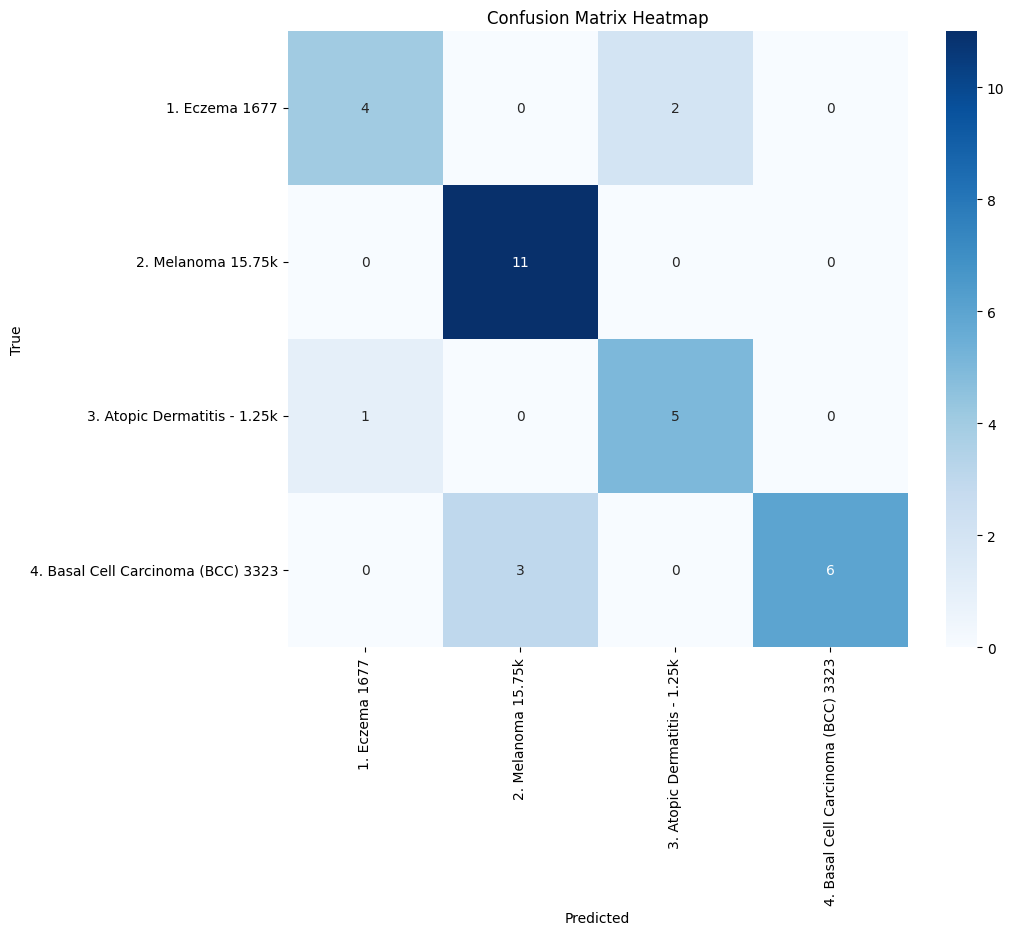

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(generator, model):
    generator.reset()
    batch = next(generator)
    images, labels = batch
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    cm = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=generator.class_indices.keys(),
                yticklabels=generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

print("\nPlotting confusion matrix heatmap...")
plot_confusion_matrix(validation_generator, model)



Plotting ROC curves...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


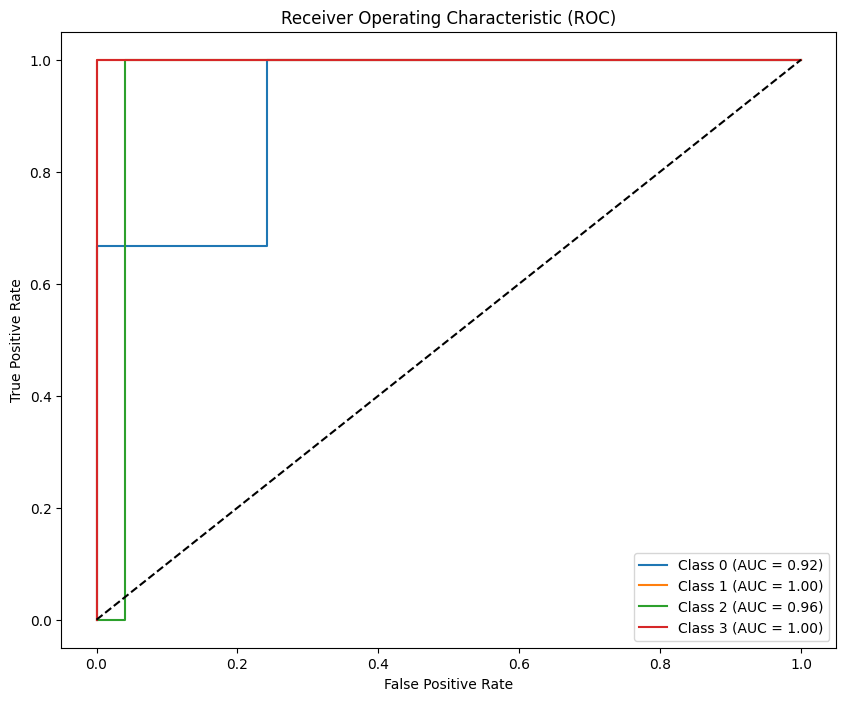

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(generator, model):
    generator.reset()
    batch = next(generator)
    images, labels = batch
    predictions = model.predict(images)

    true_labels = np.argmax(labels, axis=1)
    y_true = label_binarize(true_labels, classes=list(generator.class_indices.values()))
    y_score = predictions

    plt.figure(figsize=(10, 8))

    for i in range(len(generator.class_indices)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

print("\nPlotting ROC curves...")
plot_roc_curve(validation_generator, model)


In [ ]:
from sklearn.metrics import log_loss

def compute_log_loss(generator, model):
    generator.reset()
    batch = next(generator)
    images, labels = batch
    predictions = model.predict(images)

    true_labels = np.argmax(labels, axis=1)
    y_true = label_binarize(true_labels, classes=list(generator.class_indices.values()))
    y_score = predictions

    log_loss_value = log_loss(y_true, y_score)
    print(f"Log Loss: {log_loss_value:.4f}")

print("\nComputing log loss...")
compute_log_loss(validation_generator, model)



Computing log loss...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Log Loss: 0.5326


In [ ]:
from sklearn.metrics import accuracy_score

def compute_accuracy_score(generator, model):
    generator.reset()
    batch = next(generator)
    images, labels = batch
    predictions = model.predict(images)

    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    accuracy = accuracy_score(true_classes, predicted_classes)
    print(f"Accuracy Score: {accuracy:.4f}")

print("\nComputing accuracy score...")
compute_accuracy_score(validation_generator, model)



Computing accuracy score...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Accuracy Score: 0.7812



Visualizing predictions with Adam optimizer...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


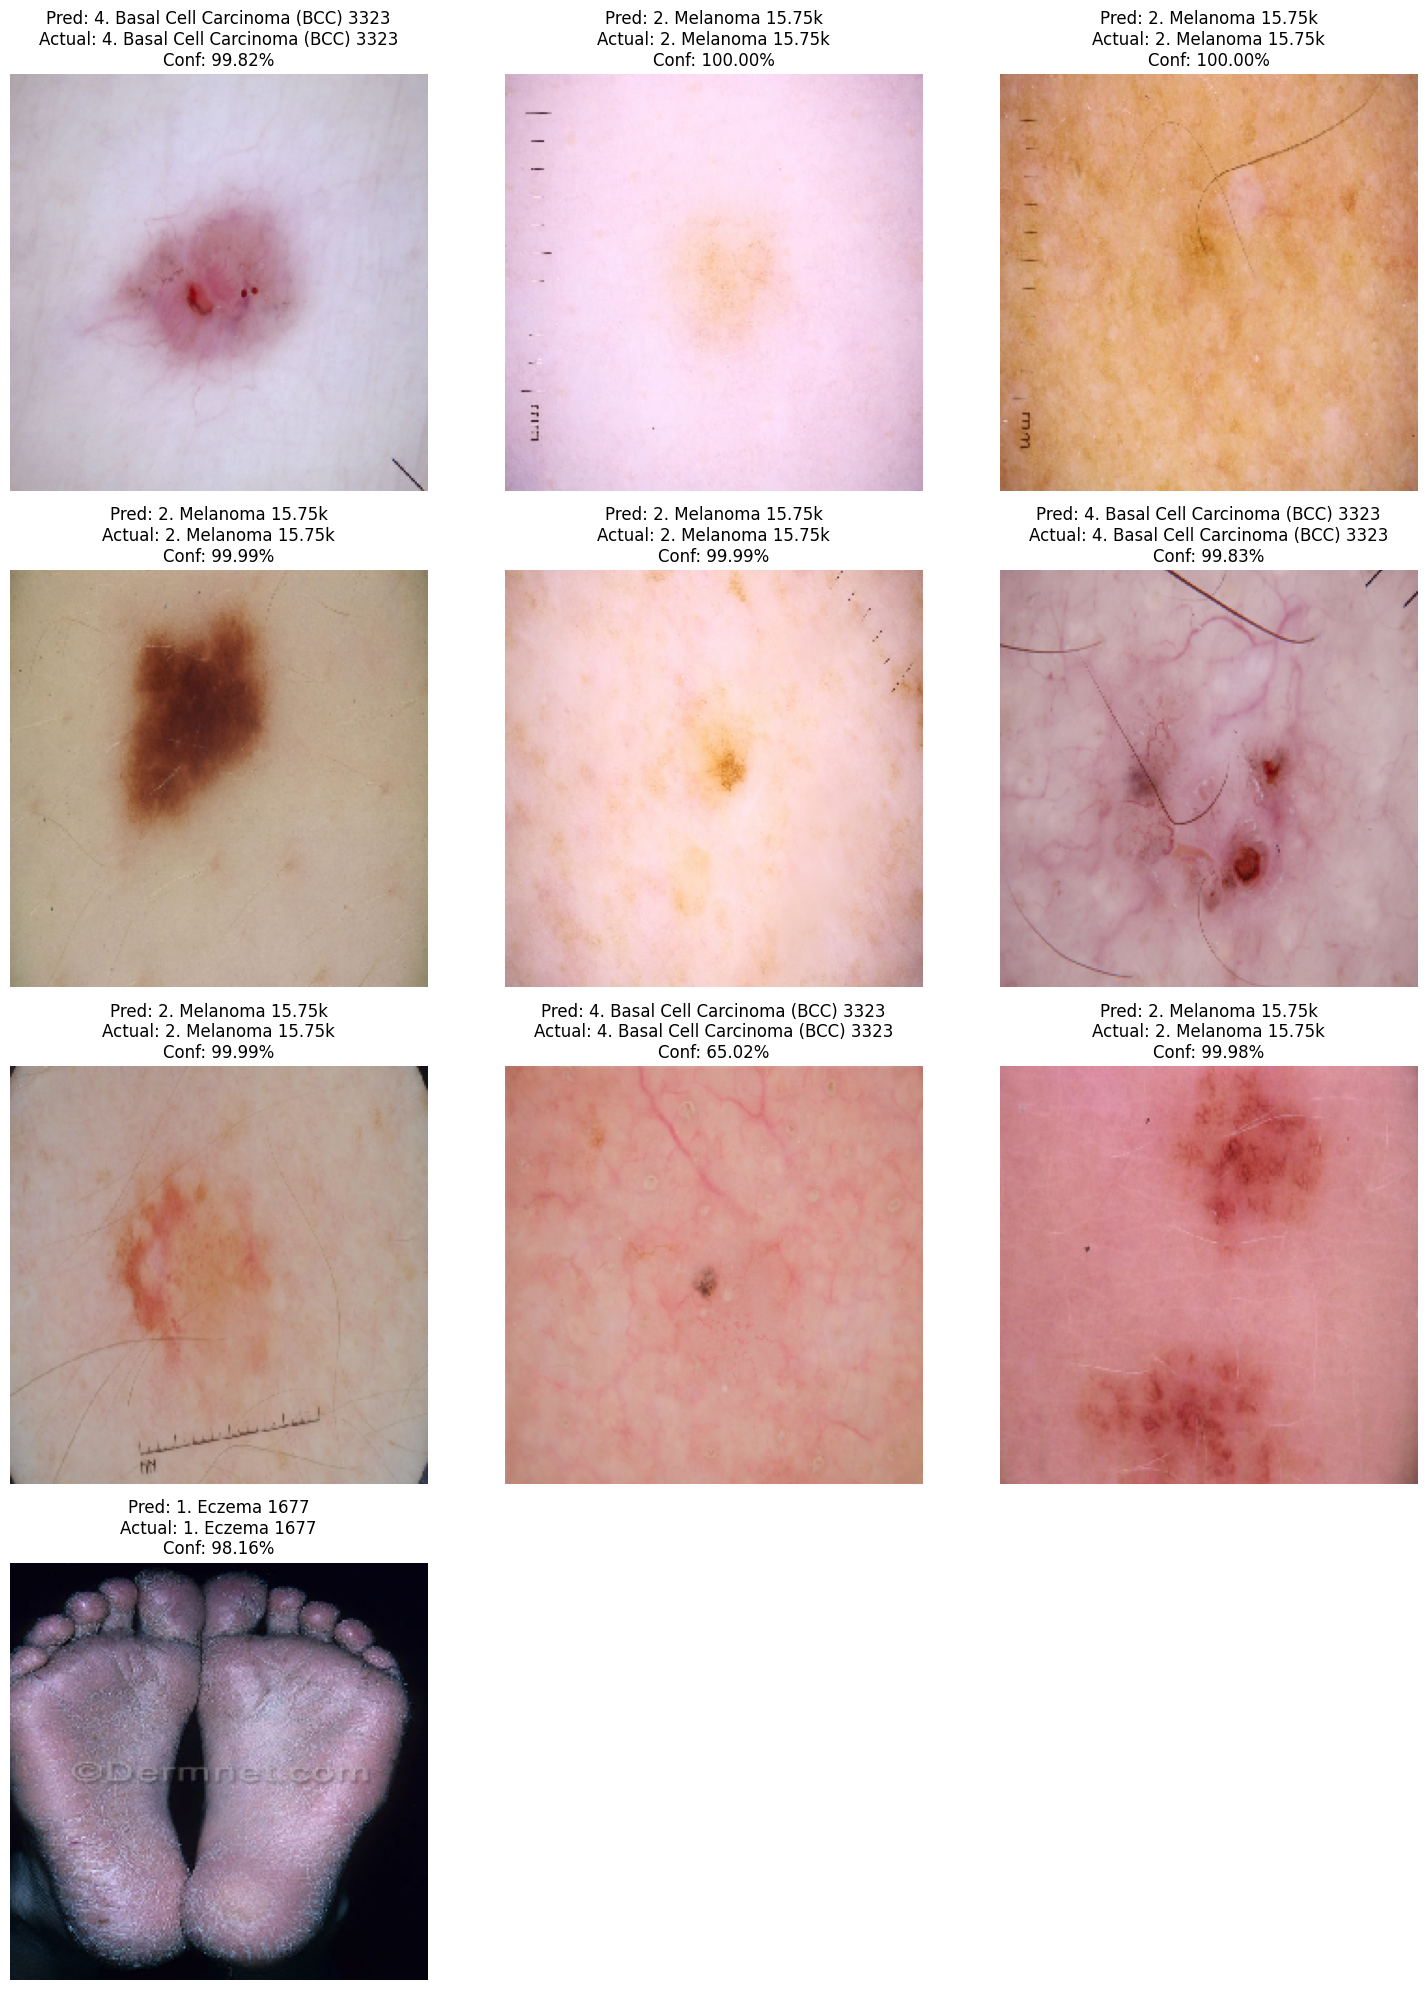

In [ ]:
def visualize_predictions_adam(generator, model, num_images=10):

    generator.reset()


    batch = next(generator)
    images, labels = batch


    predictions = model.predict(images)


    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)


    class_labels = list(generator.class_indices.keys())


    num_rows = (num_images + 2) // 3

    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Pred: {class_labels[predicted_classes[i]]}\n"
                  f"Actual: {class_labels[true_classes[i]]}\n"
                  f"Conf: {np.max(predictions[i]) * 100:.2f}%")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


print("\nVisualizing predictions with Adam optimizer...")
visualize_predictions_adam(validation_generator, model, num_images=10)


In [ ]:

model_save_path = '/content/drive/MyDrive/Colab Notebooks/saved_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/Colab Notebooks/saved_model.h5


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image


model_path = '/content/drive/MyDrive/Colab Notebooks/saved_model.h5'
model = tf.keras.models.load_model(model_path)
class_names = ['Atopic detmatitis', 'Basel cell Carcinoma', 'Eczema','Melanoma']


def predict_skin_disease(img):

    img = img.resize((224, 224))
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)
    return f"Disease: {predicted_class}, Confidence: {confidence:.2f}"


interface = gr.Interface(
    fn=predict_skin_disease,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Skin Disease Detection",
    description="Upload a skin image to detect the disease."
)


interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0ebb1c88b1f19c344a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
